# Data preparation for model training

This section includes information on how to load, and transform your dataset to be used for training a deep neural network model. We categorize the usecases into:
1. From a wide-known dataset, official dataset supported by tensorflow, or keras.
2. Customize a dataset.

In general, the target of data preparation step is to create sample data and groundtruth (X, y). By best practice, a dataset should be split into train (ratio%) and validation ((1 - ratio)%) subsets for training and validating progress. Let's clarify first the final artifact of this step:
- Training set: include X_train, y_train
- Validation set: include X_val, y_val

**The ratio of samples between validation and training set is up to you!** 

## 0. Requirement

Some dependencies need to be installed first:
- numpy 
- opencv-python
- tensorflow==2.16.1
- keras

Run:

```bash
python -m pip install numpy opencv-python tensorflow==2.16.1 keras
```

Then, make sure all of them are imported on your script file:

In [13]:
import numpy as np
import cv2
import tensorflow as tf
import os
import keras
from keras import layers

Now, let's define a model architecture for trying in the next sections

In [16]:
def create_lenet5_for_classification(input_shape, num_classes):
    return keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

## 1. From a wide-known dataset

Tensorflow and keras provide us instant API for loading the data as numpy data, sometime already normalized. These APIs help us to quick try a model architecture on a standard dataset to solve a common problem. For instant, I want to use MNIST dataset, for practice purpose, then:

In [2]:
# load the preprocessed dataset from keras
mnist_data = keras.datasets.mnist.load_data()



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# mnist_data has format (x_train, y_train), (x_test, y_test), now we unpack it
(x_train, y_train), (x_test, y_test) = mnist_data 
print('Shape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Shape: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [12]:
# mnist dataset has labels for 10 classes are 10 digits, from 0-9
mnist_labels = [str(i) for i in range(10)]

# mnist dataset by keras is shaped [28, 28] each item, has value range in [0, 255].
# then, we have to transform and normalize it before usage 
x_train = x_train.astype(np.float32) / 255.0 
x_test = x_test.astype(np.float32) / 255.0

# the operation is actually max, min scale. but the max is always 255 and the min value is always 0,
# so we just need to divide the x_train and x_test by 255 in this case
# for other tasks, it should be: x_norm = (x - min) / (max - min)

print('x_train\'s value range:', x_train.min(), x_train.max())
print('x_test\'s value range:', x_test.min(), x_test.max())

x_train's value range: 0.0 1.0
x_test's value range: 0.0 1.0


In [18]:
# as the standard, input of keras model must includes one channel dim. 
# So, we need to expand the last dimension to form a pseudo channel dim

x_train = np.expand_dims(x_train, -1) # -1 is the last dim
x_test = np.expand_dims(x_test, -1) # -1 is the last dim

print('Shape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Shape: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [19]:
# In total, we have

print(x_train.shape[0], 'training samples.')
print(x_test.shape[0], 'testing samples.')

60000 training samples.
10000 testing samples.


In [20]:
# now create a lenet model and try it

my_lenet = create_lenet5_for_classification(
    x_train.shape[1:], 
    len(mnist_labels)
)

my_lenet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

my_lenet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# train the model 

my_lenet.fit(
    x_train, 
    keras.utils.to_categorical(
        y_train, 
        len(mnist_labels)
    ),
    batch_size=128, # my pc is strong so i set it to 128. it should be lower for weaker pc
    epochs=5, 
    validation_split=0.1 # validation directly on the train set. notice that the train set will be separated into 2 parts: train and validation
)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6537 - loss: 0.1975 - val_accuracy: 0.9777 - val_loss: 0.0224
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9635 - loss: 0.0305 - val_accuracy: 0.9852 - val_loss: 0.0145
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9745 - loss: 0.0221 - val_accuracy: 0.9872 - val_loss: 0.0124
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9803 - loss: 0.0178 - val_accuracy: 0.9897 - val_loss: 0.0108
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9831 - loss: 0.0157 - val_accuracy: 0.9908 - val_loss: 0.0098


In [22]:
# eval on test set

test_loss, test_acc = my_lenet.evaluate(
    x_test,
    keras.utils.to_categorical(
        y_test,
        len(mnist_labels)
    )
)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9843 - loss: 0.0117
Test accuracy: 0.9876999855041504
Test loss: 0.009999050758779049


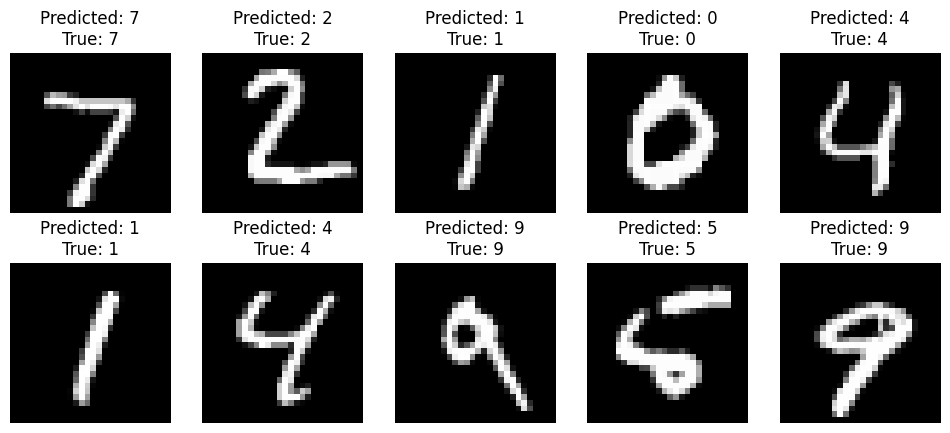

In [26]:
# visualize the result

from matplotlib import pyplot as plt 

n = 10
plt.figure(figsize=(12, 5))
for i in range(n):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title('Predicted: {}\nTrue: {}'.format(
        mnist_labels[np.argmax(my_lenet.predict(x_test[i:i+1], verbose=None))],
        mnist_labels[y_test[i]]
    ))
    plt.axis('off')
plt.show()


looks good!

## 2. Customize your dataset

This section is to help you create a training data for a specific task. The sample I use is to categorize dog and cat image using lenet5 model.

In [28]:
# at first, download it from the gdrive id
# install gdown: python -m pip install gdown

!gdown  1FP3NB3diInw-kIno5aU3w7DAZUaKFWla -O cat-dog.zip

Downloading...
From (original): https://drive.google.com/uc?id=1FP3NB3diInw-kIno5aU3w7DAZUaKFWla
From (redirected): https://drive.google.com/uc?id=1FP3NB3diInw-kIno5aU3w7DAZUaKFWla&confirm=t&uuid=3201e9ab-d1f4-483f-a18b-7846b90c800e
To: 'cat-dog.zip'

  0%|          | 0.00/570M [00:00<?, ?B/s]
  0%|          | 524k/570M [00:00<02:28, 3.83MB/s]
  0%|          | 1.57M/570M [00:00<01:39, 5.71MB/s]
  1%|          | 3.15M/570M [00:00<01:07, 8.36MB/s]
  1%|          | 4.72M/570M [00:00<01:01, 9.25MB/s]
  1%|▏         | 7.34M/570M [00:00<00:46, 12.0MB/s]
  2%|▏         | 8.91M/570M [00:01<01:13, 7.60MB/s]
  2%|▏         | 10.5M/570M [00:01<01:09, 8.05MB/s]
  2%|▏         | 11.5M/570M [00:01<01:08, 8.16MB/s]
  2%|▏         | 12.6M/570M [00:01<01:11, 7.78MB/s]
  3%|▎         | 16.3M/570M [00:01<00:41, 13.5MB/s]
  3%|▎         | 18.4M/570M [00:01<00:41, 13.2MB/s]
  3%|▎         | 19.9M/570M [00:01<00:43, 12.8MB/s]
  4%|▍         | 21.5M/570M [00:02<00:42, 13.0MB/s]
  4%|▍         | 23.6M/570M [0

In [32]:
# unpack it
import zipfile

assert os.path.exists('cat-dog.zip'), 'File not found'
with zipfile.ZipFile('cat-dog.zip', 'r') as zip_ref:
    zip_ref.extractall('cat-dog-dataset')

In [36]:
# now let's see the dataset structure

%ls cat-dog-dataset\train

 Volume in drive D is work
 Volume Serial Number is E0B1-1A91

 Directory of cat-dog-dataset\train

07/05/2024  03:11 PM    <DIR>          .
07/05/2024  03:11 PM    <DIR>          ..
07/05/2024  03:11 PM            12,414 cat.0.jpg
07/05/2024  03:11 PM            16,880 cat.1.jpg
07/05/2024  03:11 PM            34,315 cat.10.jpg
07/05/2024  03:11 PM            28,377 cat.100.jpg
07/05/2024  03:11 PM             5,944 cat.1000.jpg
07/05/2024  03:11 PM            21,944 cat.10000.jpg
07/05/2024  03:11 PM            27,322 cat.10001.jpg
07/05/2024  03:11 PM            25,723 cat.10002.jpg
07/05/2024  03:11 PM            28,035 cat.10003.jpg
07/05/2024  03:11 PM            12,973 cat.10004.jpg
07/05/2024  03:11 PM             8,245 cat.10005.jpg
07/05/2024  03:11 PM            24,153 cat.10006.jpg
07/05/2024  03:11 PM            10,328 cat.10007.jpg
07/05/2024  03:11 PM            25,222 cat.10008.jpg
07/05/2024  03:11 PM            21,281 cat.10009.jpg
07/05/2024  03:11 PM            23,0

In [37]:
# the train data file has fmt label.<id>.jpg
# now define a function to load it

import re, cv2, glob

pattern = re.compile(r'(\w+)\.(\d+)\.jpg')

labels_map = {
    'cat': 0,
    'dog': 1
}

def load_item(path):
    name = os.path.split(path)[-1]
    label, _ = pattern.match(name).groups()
    return cv2.imread(path), labels_map[label]

In [42]:
# index data files, load and split 

train_files = glob.glob('cat-dog-dataset/train/*.jpg')
print('Total data files:', len(train_files)) 

train_ratio = .7
train_files = np.random.permutation(train_files)

train_files = train_files[:int(len(train_files) * train_ratio)]
val_files = train_files[int(len(train_files) * train_ratio):]

print('Train files:', len(train_files))
print('Validation files:', len(val_files))

Total data files: 25000
Train files: 17500
Validation files: 5250


In [44]:
# now we load and transform data manually
x_train, y_train, x_test, y_test = [], [], [], []
img_input_size = (64, 64) # we use larger image for this task


In [45]:

import tqdm 

for path in tqdm.tqdm(train_files, desc='Loading train data'):
    x, y = load_item(path)

    x = cv2.resize(x, img_input_size)

    x_train.append(x)
    y_train.append(y)

for path in tqdm.tqdm(val_files, desc='Loading validation data'):
    x, y = load_item(path)

    x = cv2.resize(x, img_input_size)

    x_test.append(x)
    y_test.append(y)

# construct np.arrays for the next steps
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print('Shape:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Loading validation data: 100%|██████████| 5250/5250 [00:04<00:00, 1154.23it/s]


Shape: (17500, 64, 64, 3) (17500,) (5250, 64, 64, 3) (5250,)


In [46]:
# now normalize the data

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [47]:
# create a lenet model 
# in this task, the input is 3-channel image, so we have to change the input shape

lenet_5_cat_dog_classification_model = create_lenet5_for_classification(
    x_train.shape[1:],
    len(labels_map)
)

lenet_5_cat_dog_classification_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lenet_5_cat_dog_classification_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │        32,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,162 (203.76 KB)

 Trainable params: 52,162 (203.76 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# train the model

lenet_5_cat_dog_classification_model.fit(
    x_train,
    keras.utils.to_categorical(y_train, len(labels_map)),
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7885 - loss: 0.4613 - val_accuracy: 0.7957 - val_loss: 0.4421
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8055 - loss: 0.4204 - val_accuracy: 0.8049 - val_loss: 0.4366
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8109 - loss: 0.4128 - val_accuracy: 0.7997 - val_loss: 0.4411
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8140 - loss: 0.4119 - val_accuracy: 0.8103 - val_loss: 0.4237
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8189 - loss: 0.3928 - val_accuracy: 0.8003 - val_loss: 0.4381
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8330 - loss: 0.3774 - val_accuracy: 0.8231 - val_loss: 0.4120
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8376 - loss: 0.3671 - val_accuracy: 0.8171 - val_loss: 0.4099
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8363 - loss: 0.3694 - val_accu

In [51]:
# now we test it

test_loss, test_acc = lenet_5_cat_dog_classification_model.evaluate(
    x_test,
    keras.utils.to_categorical(y_test, len(labels_map))
)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8582 - loss: 0.3299
Test accuracy: 0.8386666774749756
Test loss: 0.36832788586616516


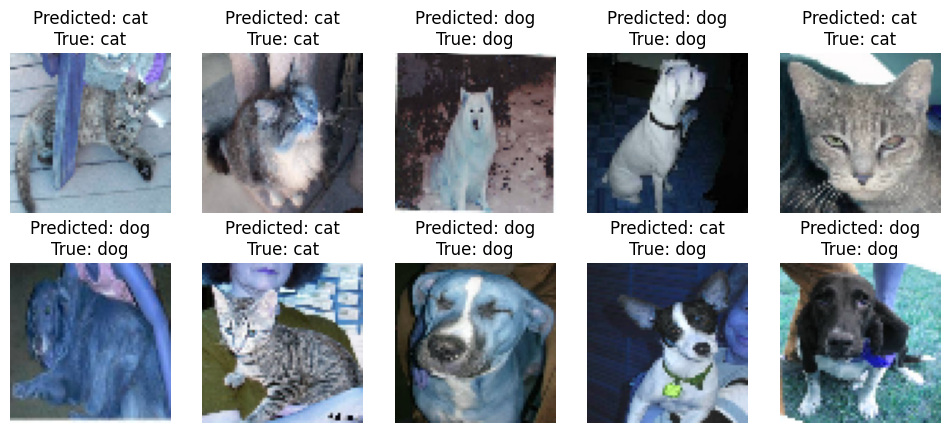

In [ ]:
# visualize the result

n = 10
plt.figure(figsize=(12, 5))

for i in range(n):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title('Predicted: {}\nTrue: {}'.format(
        list(labels_map.keys())[np.argmax(lenet_5_cat_dog_classification_model.predict(x_test[i:i+1], verbose=None))],
        list(labels_map.keys())[y_test[i]]
    ))
    plt.axis('off')